<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>

Привет Кирилл! Меня зовут Марат, и я буду твоим ревьюером. Спешу сообщить что все ключевые этапы в работе выполнены,  с задачей тебе удалось справиться. По поводу обращения - в IT сфере принято общаться на «ты» :) Но, если привычней на «вы», дай знать. Как ревьюера моя задача помочь тебе в развитии, дав хорошие советы. Я внимательно посмотрю твой код, ознакомлюсь с твоими выводами и оставлю комментарии. Где то могу предложить небольшие исправление в коде, но ненавязчиво. Где потребуются уточнения, я оставлю много наводящих вопросов. Они помогут тебя с поиском верного решения.

Все мои комментарии размечены по цветам, для лучшего восприятия. 
    
<div class="alert alert-success">Зеленым цветом и словом «Успех» отмечены особо удачные и элегантные решения, которыми ты можешь гордиться. </div>
        
<div class="alert alert-warning">Желтым и значком словом «Совет», помечены решения у которых есть альтернативные решения, более оптимальные. Ты можешь найти их сразу и доработать проект, или отложить это на потом, для будущих проектах. Проект будет принят и без их доработки. </div>
        
<div class="alert alert-danger"> Красным цветом и значком словом «Ошибка» помечу твои решения, на которые стоит обратить внимание прежде всего. После их доработки проект будет принят. </div>
        
Залог успеха - работа сообща, взаимное уважение и работа в диалоге. Поэтому, помечай свои ответные комментарии на мои реплики заметным цветом или курсивом, так мне будет легче их отслеживать. Пожалуйста, не изменяй и не удаляй мои комментарии. Все это поможет выполнить повторную проверку быстрей.

</div>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Вступление в работу очень важно, так человек, который смотрит твой проект (и на работе в том числе) будет сразу введен в курс дела. 
     
    
 

<div class="alert alert-warning">


Совет: 
   
Вопросик, при желании можешь ответить )
    
    
- а почему по твоему была выбрана метрика f1? 
    
    
- а что если бы нам было нужно найти как можно больше токсичных комментариев, в этом случаи на какую метрику мы бы ориентировались?
    
    
- каким образом мы можем изменить функцию ошибки в модели, чтобы она максимизировала интересующую нас метрику (accuracy, f1, precision, roc-auc итп)?    



</div>

## Подготовка

In [1]:
%pip install wordcloud pytorch-lightning torchmetrics

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gc
import math
import re
import os.path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import evaluate

from tqdm.notebook import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import transformers
# import (
#     BertModel,
#     BertTokenizer,
#     DistilBertModel,
#     DistilBertTokenizer
# )

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics.classification import BinaryF1Score, BinaryAUROC

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score
)

from sklearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss 

from wordcloud import WordCloud

from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import TrainingArguments, Trainer

np.random.seed(13)
torch.manual_seed(13)
torch.use_deterministic_algorithms(True)

torch.set_float32_matmul_precision('medium')

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    gc.collect()
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070


In [4]:
df = pd.read_csv('datasets/toxic_comments.csv', index_col=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [5]:
# df = df.sample(20000, random_state=12345)

In [6]:
def clear_text(text, re):
    return " ".join(re.sub(r"[^a-zA-Z ']", ' ', text).split()).lower()
    
df['text'] = df['text'].progress_apply(clear_text, re=re)

display(df)

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic
0,explanation why the edits made under my userna...,0
1,d'aww he matches this background colour i'm se...,0
2,hey man i'm really not trying to edit war it's...,0
3,more i can't make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159446,and for the second time of asking when your vi...,0
159447,you should be ashamed of yourself that is a ho...,0
159448,spitzer umm theres no actual article for prost...,0
159449,and it looks like it was actually you who put ...,0


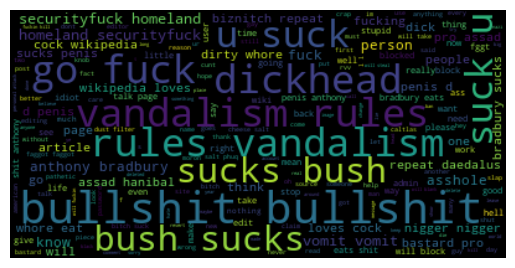

In [7]:
wordcloud = WordCloud().generate(' '.join(df[df['toxic'] == 1].sample(1000, random_state=12345)['text']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

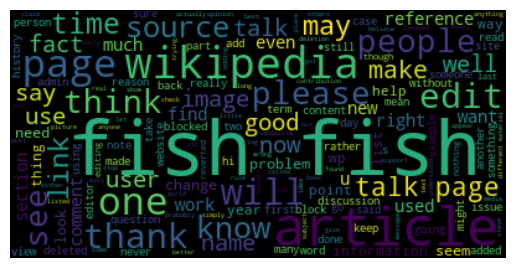

In [8]:
wordcloud = WordCloud().generate(' '.join(df[df['toxic'] == 0].sample(1000, random_state=12345)['text']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [10]:
word_len = df['text'].str.split().str.len()

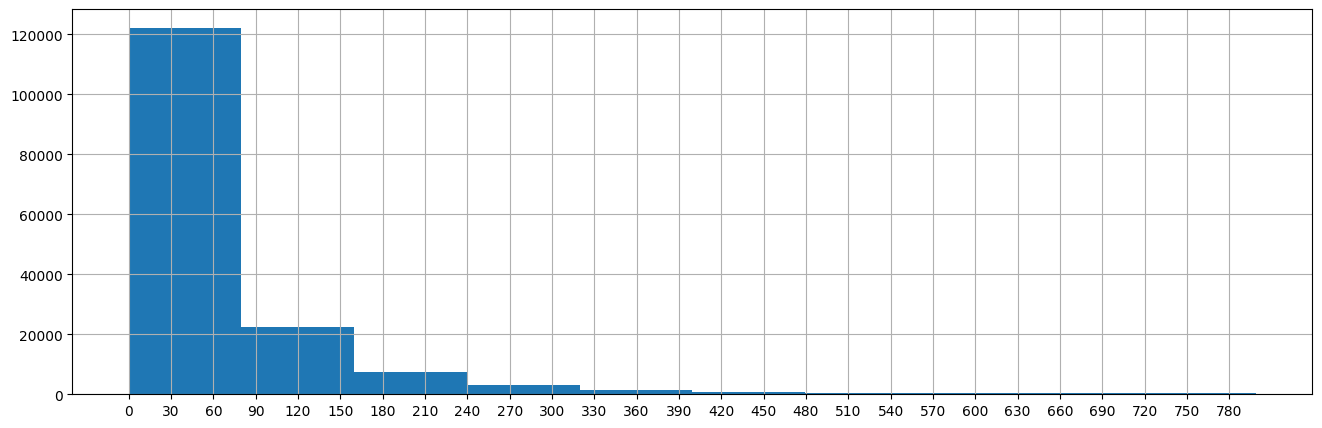

In [11]:
fig, ax = plt.subplots(figsize=(16,5))
plt.hist(word_len[word_len < 800])
plt.grid()
plt.xticks(range(0, 800, 30))
plt.show()
None

Судя по графику в большинстве текстов не более 240 слов. Установим максимальную длину предложений в tokenizer-е

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Данные изучены. Небольшой EDA не помешает, так как это аналитический проект. 


Здорово что обращено внимание на дисбаланс, и обратил внимание на количество слов в пердложении
    
    
<div class="alert alert-warning">

Совет: 





- можно провести частотный анализ текста/[облако слов](https://habr.com/ru/post/517410/) - чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных твитах Кроме того графики, рисунки делают проект визуально интересней
    
В тренажере облако импортируем так

    !/opt/conda/bin/python -m pip install wordcloud 


или

    !/opt/conda/bin/python -m pip install wordcloud==1.8.2.2  


И возможно дополнительно надо будет сделать



    !pip install --upgrade Pillow

In [12]:
CACHE_FEATURES = True
FEATURES_PATH = 'features.csv'
MAX_LENGTH = 256
TARGET_COLUMN = 'toxic'


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет: 

Есть модели обученных на специальных в текстах и предназначенные для специальных целей, их можно поискать на  на huggingface. Там авторы указывают,на каких данных учили и для каких целей, можно поискать. В частности для нашего датосета возможно будут интересна модель  toxic-bert. Судя по названию она самое то )



    
Подгрузить можно так
    
    
    model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
    tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')
    
    
    
    
В этом случае можно получить метрику за 0,95, и этот результат можно будет получить даже на тренировочной выборке в 1500 примеров (тестовую разрешается оставить > 100)

In [13]:
def get_padded_mask(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)

    padded = torch.LongTensor(padded)  
    attention_mask = torch.LongTensor(attention_mask)

    return padded, attention_mask

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:




Здорово что используешь gpu




<div class="alert alert-warning">



Совет 🤔:


    
вряд ли, но возможно найдёшь что-то интересное


[Google Colab для эффективного обучения](https://colab.research.google.com/)
    
[Как включить GPU в Google Colab](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm)
    
[Как BERT обучать на GPU](https://huggingface.co/docs/transformers/performance)    

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



Тут у тебя стандартный код из тренажёра, поэтому не комментирую



</div>


In [14]:
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

def tokenize(text, tokenizer, max_length):
    return tokenizer.encode(
        text, 
        truncation=True, 
        max_length=max_length, 
        add_special_tokens=True
    )

def get_padded_mask(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)

    padded = torch.LongTensor(padded)  
    attention_mask = torch.LongTensor(attention_mask)

    return padded, attention_mask

tokenized = df['text'].parallel_apply(tokenize, tokenizer=tokenizer, max_length=MAX_LENGTH)

padded, attention_mask = get_padded_mask(tokenized)

df['input_ids'] = padded.tolist()
df['attention_mask'] = attention_mask.tolist()

In [15]:
df

,text,toxic,input_ids,attention_mask
0,explanation why the edits made under my userna...,0,"[101, 7526, 2339, 1996, 10086, 2015, 2081, 210...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,d'aww he matches this background colour i'm se...,0,"[101, 1040, 1005, 22091, 2860, 2002, 3503, 202...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,hey man i'm really not trying to edit war it's...,0,"[101, 4931, 2158, 1045, 1005, 1049, 2428, 2025...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,more i can't make any real suggestions on impr...,0,"[101, 2062, 1045, 2064, 1005, 1056, 2191, 2151...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,you sir are my hero any chance you remember wh...,0,"[101, 2017, 2909, 2024, 2026, 5394, 2151, 3382...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...
159446,and for the second time of asking when your vi...,0,"[101, 1998, 2005, 1996, 2117, 2051, 1997, 4851...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
159447,you should be ashamed of yourself that is a ho...,0,"[101, 2017, 2323, 2022, 14984, 1997, 4426, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
159448,spitzer umm theres no actual article for prost...,0,"[101, 13183, 6290, 26114, 2045, 2015, 2053, 50...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
159449,and it looks like it was actually you who put ...,0,"[101, 1998, 2009, 3504, 2066, 2009, 2001, 2941...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [16]:
# df = df.sample(20000, random_state=12345)

In [17]:
class ReviewDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_row = self.data.iloc[index]

        text = data_row.text
        labels = data_row[TARGET_COLUMN]

        return dict(
            text=text,
            input_ids=torch.LongTensor(data_row['input_ids']),
            attention_mask=torch.LongTensor(data_row["attention_mask"]),
            labels=torch.FloatTensor([labels])
        )

In [18]:
class ReviewDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, batch_size=8):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df

  def setup(self, stage=None):
    self.train_dataset = ReviewDataset(
      self.train_df
    )
    self.test_dataset = ReviewDataset(
      self.test_df
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size
    )

In [19]:
class ReviewTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = transformers.AutoModel.from_pretrained('unitary/toxic-bert', return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
    self.validation_step_outputs = []
    

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0

    if labels is not None:
        loss = self.criterion(output, labels)
    
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)

    self.validation_step_outputs.append({"predictions": outputs, "labels": labels})
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def on_validation_epoch_end(self):
    outputs=self.validation_step_outputs
    
    self.logger.experiment.add_scalar("Train", self.current_epoch)
    self.validation_step_outputs.clear()


  def configure_optimizers(self):

    optimizer = transformers.AdamW(self.parameters(), lr=2e-5)

    scheduler = transformers.get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



👍 parallel_apply




Действительно это проект не только о НЛП, но о том как экономно и эффективно использовать ресурсы, и делать ускорялки.  Здорово что ты и ГПУ используешь, и парализацию, и сохраняешь результаты в файлик, и подобрал MAX_LENGTH


Как видно из документации и вывода модели на экран на входе 512 нейронов, на выходе текст будет представлен в размерности 768

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:



У нас векторное представление текста размерностью 768.  Я бы не стал говорить что это 768 фич


### Вывод:

Подготовлены данные для обучения, созданы embedding и релизовано сохранение, чтобы не ждать их формирования в дальнейшем.

Загружена предобучнная модель DistBert, использован GPU.

Чтобы ускорить токенизацию использован pandarallel для параллельной работы.

Установлено ограничение на длину предложения, чтобы сократить размер входных данных и ускорить работу модели.

## Обучение

In [20]:
train, test = train_test_split(df, test_size=0.4, random_state=12345, stratify=df['toxic'])
test, valid = train_test_split(test, test_size=0.5, random_state=12345, stratify=test['toxic'])

# nm = NearMiss()
# nm.fit_resample(train, train[TARGET_COLUMN])

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


- random_state на месте


- правильно разбито на 2 выборки (иногда студенты использующие GS разбивают на 3 датасета)

   



<div class="alert alert-warning">





Совет: 









- обрати внимание на аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах.  Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым. [Почитать](https://pythonru.com/baza-znanij/sklearn-train-test-split) можно тут




In [21]:
N_EPOCHS = 5
BATCH_SIZE = 12

small_train = train.sample(20000)
small_test = test.sample(5000)

steps_per_epoch=len(train)
total_training_steps = steps_per_epoch * N_EPOCHS

warmup_steps = total_training_steps
warmup_steps, total_training_steps

data_module = ReviewDataModule(
  small_train,
  small_test,
  batch_size=BATCH_SIZE
)

# model = ReviewTagger(
#   n_classes=1,
#   n_warmup_steps=warmup_steps,
#   n_training_steps=total_training_steps
# )

# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

# trainer = pl.Trainer(
#   callbacks=[early_stopping_callback],
#   max_epochs=N_EPOCHS,
# )

# trainer.fit(model, data_module)

# trained_model = ReviewTagger.load_from_checkpoint(
#   trainer.checkpoint_callback.best_model_path,
#   n_classes=1
# )

In [22]:
trained_model = ReviewTagger.load_from_checkpoint("lightning_logs/version_28/checkpoints/epoch=8-step=9000.ckpt", n_classes=1)

trained_model.eval()
trained_model.freeze()

trained_model = trained_model.to(device)

val_dataset = ReviewDataset(
  valid
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/31859 [00:00<?, ?it/s]

In [23]:
def plot_confusion_matrix(y_test, y_preds, classes):
    fig, ax = plt.subplots(figsize=(8,5))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = classes)
    cmp.plot(ax=ax)
    plt.show()

In [25]:
y_pred = predictions.round().numpy()
y_true = labels.numpy()

print('F1', f1_score(y_true, y_pred))

F1 0.9201268307413558


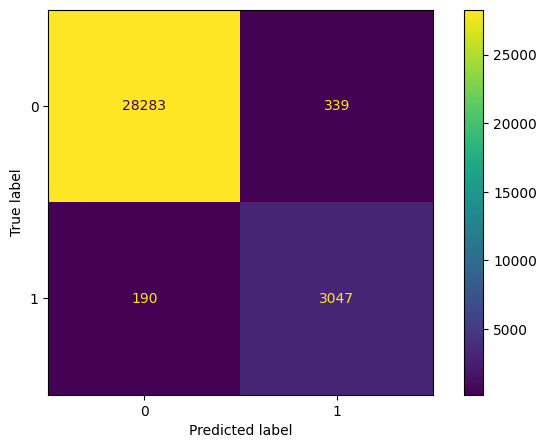

In [26]:
plot_confusion_matrix(y_true, y_pred, [0,1])

In [ ]:
# lr_pipe = Pipeline([
#     ('clf', LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced'))
# ])

# param_grid = {
#     # 'clf__solver' : ['liblinear'],
#     # 'clf__max_iter' : [2500, 5000],
#     # 'clf__C': np.linspace(0.0001, 100, 20)

#     'clf__solver' : ['liblinear'],
#     'clf__max_iter' : [2500],
#     'clf__C': [5.26325]
# }

# lr_estimator, lr_best_params, lr_best_score = search_best_estimator(lr_pipe, param_grid, train_features, train_labels)

# print('F1 cv', lr_best_score)
# print(lr_best_params)

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



здорово что реализуешь через связку pipeline+GS, хотя конечно pipeline тут не нужен 


Есть и другие варианты, подбора гиперпараметров, можешь [ознакомиться](https://www.freecodecamp.org/news/hyperparameter-optimization-techniques-machine-learning/))


In [ ]:
# clf = DummyClassifier(strategy = 'constant', constant = 1)
# clf.fit(train_features, train_labels)
# predictions = clf.predict(test_features)
# print('F1:', f1_score(test_labels, clf.predict(test_features)))

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 
    
    
Плюс за проверку.  Хотя на мой взгляд на адекватность стоит применять в разрезе метрики accuracy. А метрика f1 и без того "умная", поэтому константные модели на ней ничего интересного не покажут
    

Можешь попробовать посчитать f1    
    
    model = DummyClassifier(strategy = 'constant', constant = 1)

    
Так можно дотянуть метрику до 0,18 )   

## Выводы

Была выбрана модель /unitary/toxic-bert и с помощью Trainer выполнено ее дообучение на сэмпле датасета.

Таким  образом удалось достичь метрики F1 = 0.92

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:



Действительно TF-IDF  это уже позапрошлый день  (единственное что там можно попрактиковаться в лематизации и pipeline и feature_engenering)  
    
 
    
    
    Прошу рекомендаций куда копать и почему такая низкая точность.
    
    
    
Тут главное выбрать модель.  Действительно дело не в подборе и параметров, и не дисбалансе. 

    
    
    
    Хочется использовать Bert
    
    
Как мы вообще можем использовать Берт?  



- Можем его использовать чтобы получить эмбединги и подать их в наши модели как альтернативу векторов от TFIDF/CountVectorizer (Твой случай) - Таким образом мы получаем, (если выбрать верную модель)  метрику за 0,95. 
    
    
    
- Можно потюнить модель Берта,  можешь взять на основу [статью (там вообще все возможные варианты рассмотрены, причём с использованием разных библиотек)](https://habr.com/ru/articles/704592/) или этот [ролик](https://www.youtube.com/watch?v=Z1J3sTJYIcc&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=14), там прямо можно посмотреть процесс кодирования, и получше разобраться в практической релизации Берта (тут реализация сложнее, метрики я видел за 0,8). Если использовать [Trainer](https://pytorch.org/rl/reference/generated/torchrl.trainers.Trainer.html), будет всё гораздо проще. 
    
    
    
- И третий вариант еще проще, использовав уже готовые [модели](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html), даже без тюнинга, которые предсказывают токсичный текст на английском или нет. Использовав эту [схему](https://huggingface.co/unitary/toxic-bert), я видел полученную метрику за 0,9, даже без тюнинга 


    
Можешь и так покрутить Берта   
    


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>



Кирилл, у тебя старательно выполненная работа, все четко, осмысленно. Здорово что используешь современные подходы


Я оставил небольшие советы и вопросики (если есть время и желание можешь воспользоваться/ответить).
    


Всё отлично, осталось только поднять метрику

<font color='green'><b>Полезные (и просто интересные) материалы:</b> \
Для работы с текстами используют и другие подходы. Например, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.\
https://huggingface.co/transformers/model_doc/bert.html \
https://t.me/renat_alimbekov \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
https://transformer.huggingface.co/ - поболтать с трансформером \
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множествореализованных
методов для трансформеров методов NLP \
Word2Vec https://radimrehurek.com/gensim/models/word2vec.html 


Если понравилась работа с текстами, то можешь посмотреть очень интересный (но очень-очень сложный) курс лекций: https://github.com/yandexdataschool/nlp_course .

Если нравится смотреть и слушать то есть целый курс на Ютубе https://www.youtube.com/watch?v=qDMwIQRQt-M&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=1


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны